# Simulation on short-edge-support for adaLasso


In what follows, we illustrate the performance of short edge detection of adaptive Lasso (multi-step) on simulated data sets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import phyloinfer as pinf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import clock
import pandas as pd
import re
from p4 import *

In [4]:
from model import PHY
from optimizer import adaLasso, raxml
from utils import readTree, readEdgeSupport, addLabel, maptaxonname, Collapse, splitSupport

## Load the tree and set up the model

In [5]:
# load simulated tree
true_tree = readTree('../data/simulation/true_tree_100tips_final.newick', tree_format=3)[0]
pinf.tree.init(true_tree, name='interior')

true_branch = pinf.branch.get(true_tree)
short_idx = np.where(true_branch==0.002)[0]

# Jukes-Canter evolutionary model
pden = np.array([0.25, 0.25, 0.25, 0.25])
D, U, U_inv, rate_matrix = pinf.rateM.decompJC()

## Run multistep adaptive phylogenetic LASSO

In [ ]:
short_lens = [0.0, 0.002, 0.004, 0.006, 0.008, 0.010]

lam = 1e-06
beta = 0.5
gamma_ada_penalized = 1.0
gamma_phy = 50

brlen_ada_list = []
short_edge_prec_list = []

output_file = "../results/short_len_detection_gamma10.txt"
short_len_detection_file = open(output_file, 'w')


nrep = 100
for short_len in short_lens:
    short_edge_prec = []
    short_len_detection_file.write('short_len={:.3f}:\t'.format(short_len))
    for n in range(nrep):
        true_branch[short_idx] = short_len
        pinf.branch.set(true_tree, true_branch)
        
        data = pinf.data.treeSimu(true_tree, D, U, U_inv, pden, 1000)
        model = PHY(pden, ('JC',1.0), data)
        brlen_init = np.random.exponential(scale=0.1, size=2*model.ntips-3)
        
        start = clock()
        brlen_ada_lasso, objval_ll_ada_lasso, objval_lasso_ada_lasso, n_zeros_ada_lasso, lam_tuned_ada_lasso = adaLasso(model, true_tree, brlen_init, lam, gamma=gamma_phy, beta=beta, prox='l1', msteps=3, gamma_ada_penalized=gamma_ada_penalized, sparsity_monitor=True)
        
        print "\nlambda = {}; step size = {}; elapsed time = {:.04f} second".format(gamma_phy, lam_tuned_ada_lasso, clock()-start)
        
#         pdb.set_trace()
        brlen_ada_list.append(brlen_ada_lasso[-1])
        short_edge_prec.append(sum(brlen_ada_list[-1][short_idx]>0)/15.0)
        
        short_len_detection_file.write('{:.2f}\t'.format(short_edge_prec[-1]))
        short_len_detection_file.flush()
                
        plt.plot(objval_ll_ada_lasso, label="LL")
        plt.plot(objval_lasso_ada_lasso, label="LL+Penalty")
        plt.legend(loc=4, fontsize=15)
        plt.show()
    
    short_edge_prec_list.append(short_edge_prec)
    short_len_detection_file.write('\n') 

short_len_detection_file.close()

## Run rjMCMC in p4

In [ ]:
def rjmcmc(init_tree_seq, data_seq, sampleInterval, checkPointInterval, nIter):
    read(init_tree_seq)
    init_tree = var.trees.pop()
    read(data_seq)
    
    data = Data()
    taxa = data.taxNames
    init_tree.data = data
    
    init_tree.newComp(free=0, spec='equal')
    init_tree.newRMatrix(free=0, spec='ones')
    init_tree.setNGammaCat(nGammaCat=1)
    init_tree.setPInvar(free=0, val=0.0)
    
    m = Mcmc(init_tree, nChains=4, runNum=0, sampleInterval=sampleInterval, checkPointInterval=checkPointInterval)
    m.prob.polytomy = 1.0
    m.prob.brLen = 0.1
    m.prob.local = 0.3
    m.prob.eTBR = 0.3
    m.tunings.chainTemp = 0.0

    m.run(nIter)
    var.alignments.pop()

In [ ]:
taxon_names = ['A{}'.format(i) for i in range(100)]
read('../data/simulation/true_tree_100tips_final_renamed.newick')
target_tree = var.trees.pop()

target_tree.taxNames = taxon_names
short_branch_dict = {}
target_tree.makeSplitKeys()
for n in target_tree.iterInternalsNoRoot():
    if n.br.len == 0.002:
        short_branch_dict[n.br.splitKey] = n
        

short_lens = [0.0, 0.002, 0.004, 0.006, 0.008, 0.010]

short_edge_prec_rjmcmc_list = []

output_file = "../results/short_len_detection_rjmcmc.txt"
init_tree_seq = '../data/simulation/init_tree_100tips_final_renamed.newick'
simu_data_seq = "../data/simulation/simu_data.fasta"
short_len_detection_file = open(output_file, 'w')


nrep = 100
for short_len in short_lens:
    short_edge_prec_rjmcmc = []
    short_len_detection_file.write('short_len={:.3f}:\t'.format(short_len))
    for n in range(nrep):
        true_branch[short_idx] = short_len
        pinf.branch.set(true_tree, true_branch)
        
        data = pinf.data.treeSimu(true_tree, D, U, U_inv, pden, 1000)
        pinf.data.saveData(data, taxon_names, simu_data_seq, 'fasta')
        
        var.trees, var.alignments = [], []
        ! rm mcmc_checkPoint*
        rjmcmc(init_tree_seq, simu_data_seq, 50, 2500, 10000)
        
        read('mcmc_trees_0.nex')
        rjmcmc_split = splitSupport(var.trees, short_branch_dict, taxon_names, collapse_threshold = 0.0, skip=0.2)
        short_edge_prec_rjmcmc.append(sum(rjmcmc_split.values())*1.0/(100*len(rjmcmc_split.values())))
        
        short_len_detection_file.write('{:.2f}\t'.format(short_edge_prec_rjmcmc[-1]))
        short_len_detection_file.flush()        
    
    short_edge_prec_rjmcmc_list.append(short_edge_prec_rjmcmc)
    short_len_detection_file.write('\n') 

short_len_detection_file.close()

## Result analysis

In [6]:
short_edge_prec_list = readEdgeSupport('../results/short_len_detection_gamma10.txt')
df = pd.DataFrame(short_edge_prec_list, columns=['0.000', '0.002', '0.004', '0.006', '0.008','0.010'])
df['method'] = ['adaLASSO']*100

In [7]:
short_edge_prec_rjmcmc_list = readEdgeSupport('../results/short_len_detection_rjmcmc.txt')
df_rjmcmc = pd.DataFrame(short_edge_prec_rjmcmc_list)
df_rjmcmc['method'] = ['rjMCMC']*100
df = pd.concat([df, df_rjmcmc])

In [8]:
# merge the results
df_melt = pd.melt(df, id_vars=['method'], value_vars=['0.000', '0.002', '0.004', '0.006', '0.008', '0.010'], var_name='branch length', value_name='detection probability')

In [9]:
# set plot color and style
current_palette = ['#ff7f0e','#1f77b4','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
sns.set_style("white")

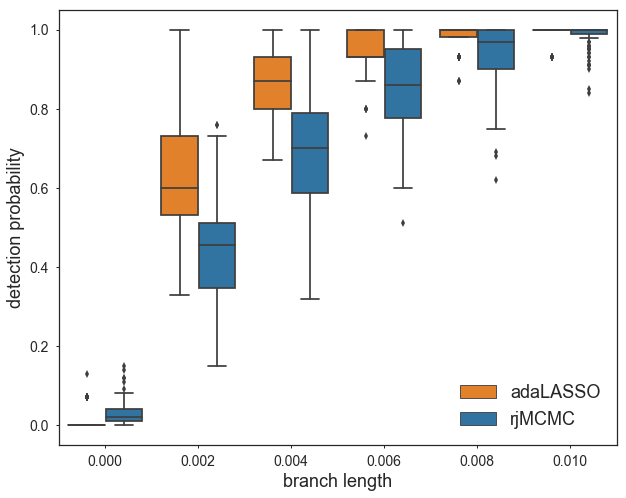

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='branch length',y='detection probability',hue='method',data=df_melt,palette=current_palette, ax=ax)
ax.legend(fontsize=18)
ax.set_xlabel('branch length',fontsize=18)
ax.set_ylabel('detection probability',fontsize=18)
ax.tick_params(labelsize=14,length=3)
plt.show()